In [2]:
import sys
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from PIL import Image
import torch

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from unet.dice_score import dice_coeff
import torch.nn as nn

In [3]:
df = pd.read_csv(
    "/net/scratch/jmoehring/checkpoints/10k_1024px_60epochs_3fold_bf1/10k_1024px_60epochs_3fold_bf1.csv"
)

In [4]:
eval_df = df.query("epoch == 60")

In [28]:
df_grouped_2 = df_grouped.groupby("treshold")["f1"].mean().reset_index()

In [30]:
df_grouped["biome"].value_counts()

biome
4.0     1394088
12.0      95624
5.0       66024
6.0       42000
13.0       3784
Name: count, dtype: int64

In [29]:
df_grouped_2.head(10)

,treshold,f1
0,0.1,0.478899
1,0.2,0.477516
2,0.3,0.476211
3,0.4,0.474674
4,0.5,0.472933
5,0.6,0.471255
6,0.7,0.469725
7,0.8,0.467768


In [6]:
df_grouped.head()

,Unnamed: 0,treshold,precision,recall,f1,ce_loss,dice_loss,biome,resolution_bin,fold,epoch
38210288,38210288,0.1,0.680812,0.317309,0.432869,0.605233,0.563724,5.0,0.1,1,60
38210289,38210289,0.2,0.682659,0.310818,0.427151,0.605233,0.563724,5.0,0.1,1,60
38210290,38210290,0.3,0.685193,0.304556,0.421682,0.605233,0.563724,5.0,0.1,1,60
38210291,38210291,0.4,0.687199,0.297960,0.415684,0.605233,0.563724,5.0,0.1,1,60
38210292,38210292,0.5,0.690135,0.291979,0.410350,0.605233,0.563724,5.0,0.1,1,60


In [20]:
# loss function (binary cross entropy)
criterion = nn.BCEWithLogitsLoss()

In [45]:
target = torch.Tensor([[0, 0], [0, 1]])
input = torch.Tensor([[0, 0], [0, 1]])
target = target.unsqueeze(2)
input = input.unsqueeze(2)
# Broadcast the values along the third dimension to make them 2x2x12
target = target.expand(2, 2, 12)
input = input.expand(2, 2, 12)
target = target.permute(2, 0, 1)
input = input.permute(2, 0, 1)

input[6, 0, 0] = 0.5

In [37]:
criterion(input, target)

tensor(0.6684)

In [46]:
dice_coeff(input, target)

tensor(0.8000)

In [31]:
df = pd.read_csv("/net/scratch/jmoehring/tiles_register_1024_biome.csv")

In [33]:
df.query("biome == 13").head(100)

,base_file_name,file_path,resolution,x,y,label_quality,resolution_bin,original,biome
108714,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.04,3426,3948,3.0,0.04,False,13.0
108715,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.04,3938,3495,3.0,0.04,False,13.0
108716,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.04,4903,3495,3.0,0.04,False,13.0
108717,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.04,4450,3495,3.0,0.04,False,13.0
108718,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.04,3426,2983,3.0,0.04,False,13.0
...,...,...,...,...,...,...,...,...,...
108809,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.01,14218,16542,3.0,0.00,True,13.0
108810,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.01,16266,11934,3.0,0.00,True,13.0
108811,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.01,21898,12446,3.0,0.00,True,13.0
108812,southafrica_B36_202309_OM1_hires-002.tif,/net/scratch/jmoehring/tiles_1024/southafrica_...,0.01,20874,12446,3.0,0.00,True,13.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200190 entries, 0 to 200189
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   base_file_name  200190 non-null  object 
 1   file_path       200190 non-null  object 
 2   resolution      200190 non-null  float64
 3   x               200190 non-null  int64  
 4   y               200190 non-null  int64  
 5   label_quality   200190 non-null  float64
 6   resolution_bin  200190 non-null  float64
 7   original        200190 non-null  bool   
 8   biome           200190 non-null  float64
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 12.4+ MB


In [6]:
df2 = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215181 entries, 0 to 1215180
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   base_file_name  1215181 non-null  object 
 1   file_path       1215181 non-null  object 
 2   resolution      1215181 non-null  float64
 3   x               1215181 non-null  int64  
 4   y               1215181 non-null  int64  
 5   label_quality   1193120 non-null  float64
 6   biome           1215181 non-null  float64
 7   resolution_bin  1215181 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 74.2+ MB


In [11]:
image_path = "/net/scratch/jmoehring/tiles_1024/quebec_2021-10-07-sbl-cloutier-z2-rgb/0.019/9764_23361_mask.tif"

In [12]:
image = Image.open(image_path).convert("RGB")

FileNotFoundError: [Errno 2] No such file or directory: '/net/scratch/jmoehring/tiles_1024/quebec_2021-10-07-sbl-cloutier-z2-rgb/0.019/9764_23361_mask.tif'

In [107]:
mask_src = rasterio.open(
    "/net/scratch/jmoehring/inference/100k_samples_biome_stratified_treefold_smallval_testset/uavforsat_2017_CFB050_ortho.tif"
)

In [4]:
image_src = rasterio.open("/net/home/jmoehring/standing-deadwood/download.tif")

In [109]:
contours = measure.find_contours(image=mask_src.read(1), level=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


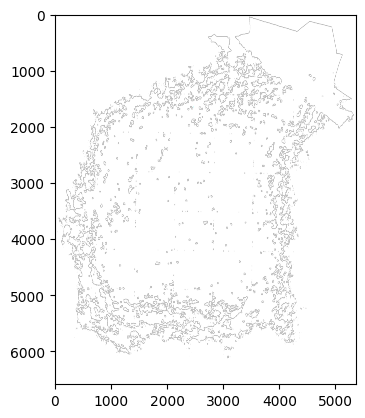

In [5]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(np.moveaxis(image_src.read(), 0, -1), cmap=plt.cm.gray)


# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="orange")

ax.axis()
ax.set_xlim(0, image_src.width)
ax.set_ylim(image_src.height, 0)

# ax.set_xlim(10500, 14500)
# ax.set_ylim(14500, 10500)

plt.show()

In [ ]:
plt.savefig("contour1.png", dpi=100)

In [39]:
contours

[array([[ 397.5, 2127. ],
        [ 397.5, 2126. ],
        [ 397.5, 2125. ],
        [ 397.5, 2124. ],
        [ 397.5, 2123. ],
        [ 397.5, 2122. ],
        [ 397.5, 2121. ],
        [ 397.5, 2120. ],
        [ 397. , 2119.5],
        [ 396.5, 2119. ],
        [ 396.5, 2118. ],
        [ 396.5, 2117. ],
        [ 396. , 2116.5],
        [ 395.5, 2116. ],
        [ 395.5, 2115. ],
        [ 395.5, 2114. ],
        [ 395. , 2113.5],
        [ 394.5, 2113. ],
        [ 394.5, 2112. ],
        [ 394.5, 2111. ],
        [ 394.5, 2110. ],
        [ 394.5, 2109. ],
        [ 394. , 2108.5],
        [ 393.5, 2108. ],
        [ 393.5, 2107. ],
        [ 393. , 2106.5],
        [ 392.5, 2106. ],
        [ 392.5, 2105. ],
        [ 392. , 2104.5],
        [ 391.5, 2104. ],
        [ 391. , 2103.5],
        [ 390.5, 2103. ],
        [ 390. , 2102.5],
        [ 389.5, 2102. ],
        [ 389. , 2101.5],
        [ 388.5, 2101. ],
        [ 388.5, 2100. ],
        [ 388. , 2099.5],
        [ 38

In [3]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [4]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215181 entries, 0 to 1215180
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   base_file_name  1215181 non-null  object 
 1   file_path       1215181 non-null  object 
 2   resolution      1215181 non-null  float64
 3   x               1215181 non-null  int64  
 4   y               1215181 non-null  int64  
 5   label_quality   1193120 non-null  float64
 6   biome           1215181 non-null  float64
 7   resolution_bin  1215181 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 74.2+ MB


In [5]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()

In [155]:
register_df[register_df["file_path"].str.contains("13905_8833.tif")]

,base_file_name,file_path,resolution,x,y,label_quality,biome,resolution_bin
317072,uavforsat_2017_CFB036_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.009,13905,8833,3.0,4.0,0.0


<Axes: >

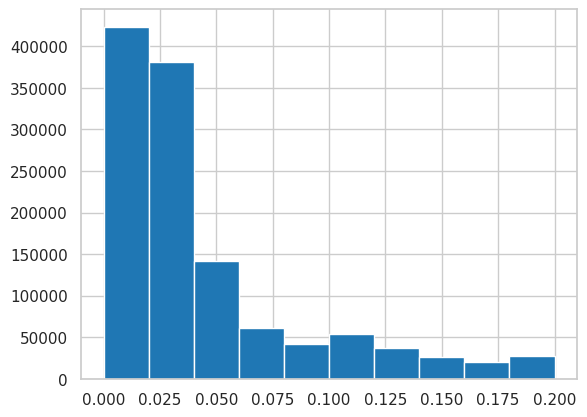

In [6]:
register_df["resolution_bin"].hist()

In [7]:
register_df["resolution_bin_str"].nunique()

KeyError: 'resolution_bin_str'

In [10]:
# Calculate the value counts
value_counts = register_df["resolution_bin"].value_counts()

# Calculate the square root of the counts
sqrt_counts = value_counts.apply(lambda x: x**0.6)

# get the inverse of the square root
class_weights = 1 / sqrt_counts

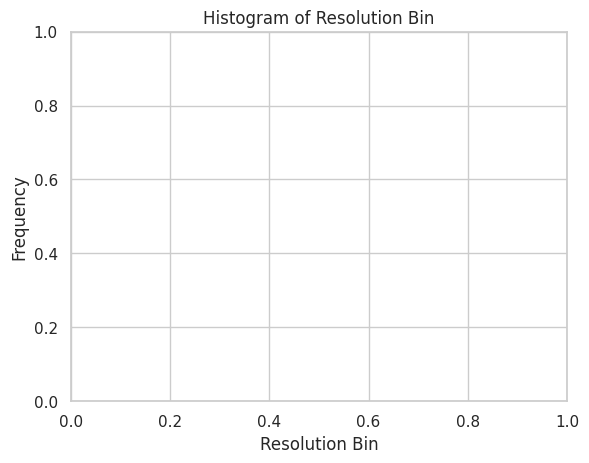

In [14]:
import seaborn as sns

# plot hisogram with value counts multiplied by the class weights
# Set the style and context of seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

# Plot the histogram
register_df["resolution_bin"].map(class_weights)


# Set the title and labels
plt.title("Histogram of Resolution Bin")
plt.xlabel("Resolution Bin")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [125]:
sample_weights = train_register["resolution_bin"].map(class_weights)

In [122]:
normalized_counts

resolution_bin
0.00    0.028135
0.02    0.029635
0.04    0.048648
0.06    0.074234
0.10    0.078598
0.08    0.089219
0.12    0.094913
0.14    0.112642
0.16    0.129759
0.18    0.146945
0.20    0.167271
Name: count, dtype: float64

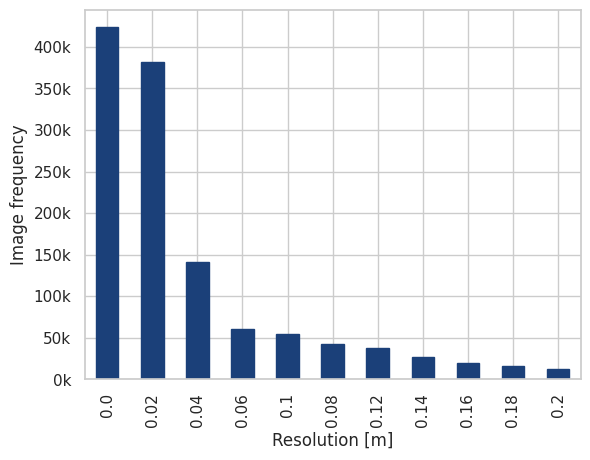

In [28]:
fig = (
    register_df["resolution_bin"]
    .value_counts()
    .plot(kind="bar", xlabel="Resolution [m]", ylabel="Image frequency")
)
import matplotlib.ticker as ticker

ax = plt.gca()  # get the current axes
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:0.0f}k".format(x / 1000))
)

# set bar color to #1B4079 all children
for i, bar in enumerate(fig.patches):
    bar.set_color("#1B4079")

# save the figure
plt.savefig("resolution_bin_histogram.png", dpi=800)

In [22]:
fig.savefig("resolution_bin_histogram.png")

AttributeError: 'Axes' object has no attribute 'savefig'

In [16]:
rounded_inverse_counts.plot(kind="bar")

NameError: name 'rounded_inverse_counts' is not defined

In [104]:
from sklearn.model_selection import StratifiedKFold

base_file_register = (
    register_df.groupby("base_file_name")
    .agg({"resolution_bin": "min", "biome": "first"})
    .reset_index()
)
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# get the train and test file register of the first fold
train_index, test_index = list(
    kfold.split(base_file_register, base_file_register[["biome"]].astype(str))
)[0]
train_files = base_file_register.iloc[train_index]
test_files = base_file_register.iloc[test_index]

train_register = register_df[
    register_df["base_file_name"].isin(train_files["base_file_name"])
]
test_register = register_df[
    register_df["base_file_name"].isin(test_files["base_file_name"])
]

/net/home/jmoehring/.conda/envs/standing-deadwood-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [101]:
base_file_register.head()

,base_file_name,resolution_bin,biome
0,20191016_FVA_Walddrohnen_Totholz_8_ortho.tif,0.02,4.0
1,20191024_FVA_Walddrohnen_Totholz_7_ortho.tif,0.02,4.0
2,20200720_FVA_Walddrohnen_Totholz_6_ortho.tif,0.00,4.0
3,20210727_FVA_Walddrohnen_Totholz_5_ortho.tif,0.00,4.0
4,20211001_FVA_Walddrohnen_Totholz_3_ortho.tif,0.02,4.0


<Axes: >

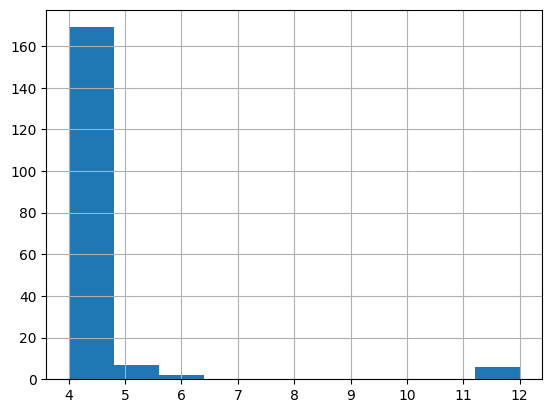

In [102]:
train_files["biome"].hist()

<Axes: >

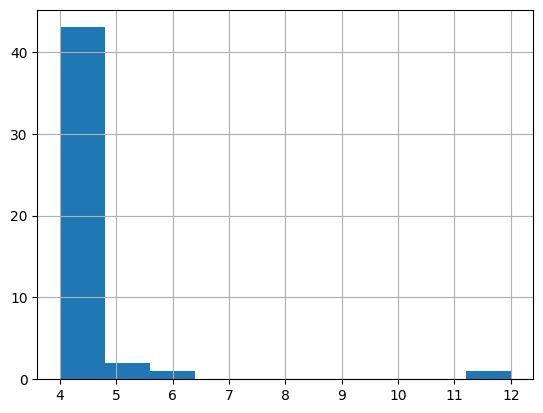

In [103]:
test_files["biome"].hist()

In [6]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
run_id = "garg20i1"
api = wandb.Api()
experiment = api.run(f"jmoehring/standing-deadwood-unet-pro/{run_id}")

In [5]:
fold = 0
epoch = 19

In [6]:
eval_df_1 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{0}_epoch_{19}.csv"
)

In [7]:
eval_df_2 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{1}_epoch_{12}.csv"
)

In [8]:
eval_df_3 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{2}_epoch_{20}.csv"
)

In [28]:
eval_df_4 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_100k_samples_biome_stratified_onefold_val_fold_0_epoch_20.csv"
)

In [9]:
# union of the two dataframes
eval_df = pd.concat([eval_df_1, eval_df_2, eval_df_3])

In [5]:
# add new column biome names
biome_names = {
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    12: "Mediteranean Forests",
    13: "Deserts and Xeric Shrublands",
}
eval_df["biome_name"] = eval_df["biome"].map(biome_names)

/tmp/ipykernel_424076/3884058455.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df["biome_name"] = eval_df["biome"].map(biome_names)


In [16]:
eval_df_t = eval_df[eval_df["treshold"] == 0.1]

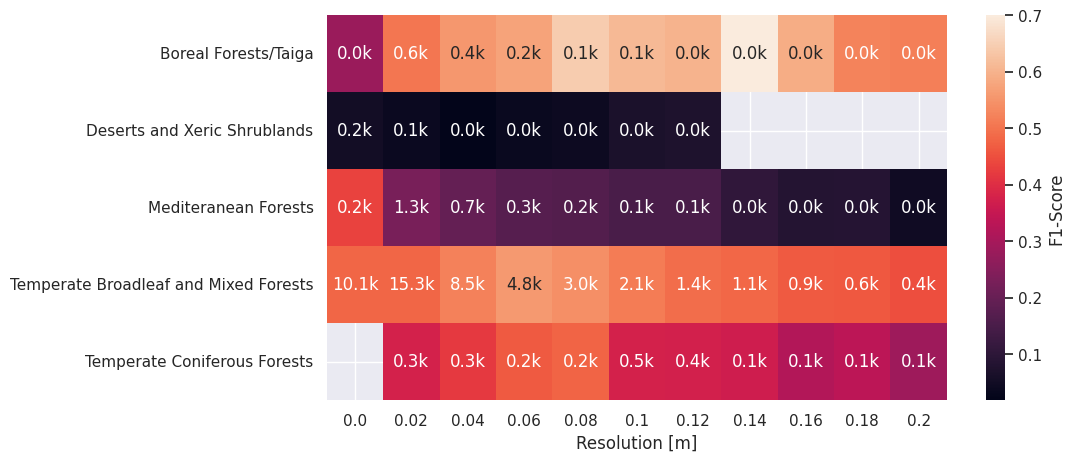

In [22]:
sns.set_theme()
pivoted = eval_df_t.pivot_table(
    index="biome_name", columns="resolution_bin", values="f1"
)
pivoted_labels = (
    eval_df_t.pivot_table(
        index="biome_name",
        columns="resolution_bin",
        values="f1",
        aggfunc="count",
    )
    / 1000
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=pivoted_labels,
    fmt=".1f",
    cbar_kws={"label": "F1-Score"},
)
# add "k" after the numbers
for t in ax.texts:
    t.set_text(t.get_text() + "k")

ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(10, 5)
plt.show()

In [14]:
eval_df_b = eval_df[eval_df["biome"] == 12]

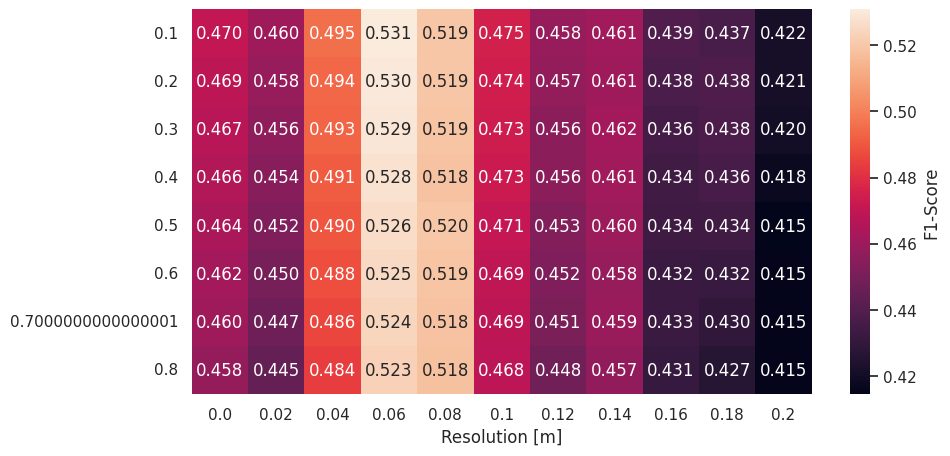

In [18]:
sns.set_theme()
pivoted = eval_df.pivot_table(
    index="treshold", columns="resolution_bin", values="f1", aggfunc="mean"
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=True,
    fmt=".3f",
    cbar_kws={"label": "F1-Score"},
)

ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(10, 5)
plt.show()

In [57]:
fig.savefig("f1_score_heatmap.png", dpi=800, bbox_inches="tight")

In [25]:
eval_df["biome"].value_counts()

biome
4.0     633830
12.0     49894
5.0      20321
Name: count, dtype: int64

In [26]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()